In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
train_df.head()

label  pixel0  pixel1    ...     pixel781  pixel782  pixel783
0      1       0       0    ...            0         0         0
1      0       0       0    ...            0         0         0
2      1       0       0    ...            0         0         0
3      4       0       0    ...            0         0         0
4      0       0       0    ...            0         0         0

[5 rows x 785 columns]

In [3]:
from keras.utils.np_utils import to_categorical
train_y = train_df['label']

#Converts a class vector (integers) to binary class matrix.
train_y = to_categorical(train_y,num_classes = 10)

train_X = train_df.drop(columns=['label'])
train_X.head()

Using TensorFlow backend.


pixel0  pixel1  pixel2    ...     pixel781  pixel782  pixel783
0       0       0       0    ...            0         0         0
1       0       0       0    ...            0         0         0
2       0       0       0    ...            0         0         0
3       0       0       0    ...            0         0         0
4       0       0       0    ...            0         0         0

[5 rows x 784 columns]

In [4]:
# Normalize the data
train_X = train_X / 255.0
test_df = test_df / 255.0

print(train_X.shape)
# reshape
train_X = train_X.values.reshape(-1,28,28,1)
test_X = test_df.values.reshape(-1,28,28,1)
print(train_X.shape)

(42000, 784)
(42000, 28, 28, 1)


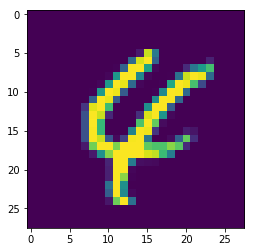

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the train and the validation set for the fitting
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_y, test_size = 0.1, random_state=5)

plt.imshow(train_X[10][:,:,0])

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

def model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    model.compile(optimizer = Adam(), loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
from keras.callbacks import Callback
from IPython.display import clear_output

%matplotlib inline
# plot for training
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();


plot = PlotLearning()

In [8]:
from keras.callbacks import ModelCheckpoint

###
### This is the function that allows you to find the weight of the best result
### after that, you can load the weight and save it as your best model
### epoch is the number of epoch for your model
### dir_path is the output directory path, path where you store your weight
### num_ext is the number of character for your weight extension, example: .hdf5
### ext is your extension, example: .hdf5
###
def save_best_model(epoch, dir_path, num_ext, ext):
    tmp_file_name = os.listdir(dir_path)
    test = []
    num_element = -num_ext

    for x in range(0, len(tmp_file_name)):
        test.append(tmp_file_name[x][:num_element])
        float(test[x])
        
    highest = max(test)

    return str(highest) + ext




In [9]:
file_path = "../n_output"
directory = os.path.dirname(file_path)

try:
    os.makedirs("../n_output")
except FileExistsError:
    # directory already exists
    pass

print(os.listdir("../n_output"))

[]


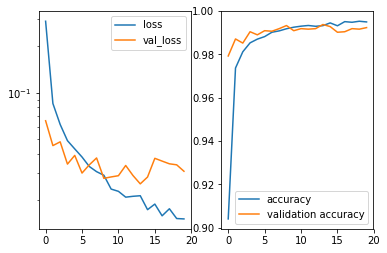


Epoch 00020: val_acc did not improve from 0.99381


In [10]:
epochs = 20
batch_size = 128
checkpoint = ModelCheckpoint('../n_output/{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

my_model = model()
my_model.fit(train_X, train_Y, batch_size = batch_size, epochs = epochs,validation_data = (val_X, val_Y),callbacks=[plot,checkpoint])

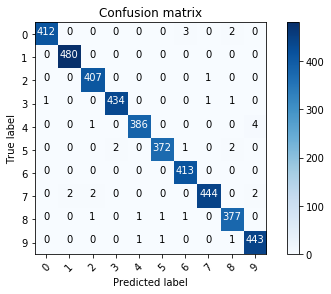

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = my_model.predict(val_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(val_Y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

../n_output/0.9938.hdf5


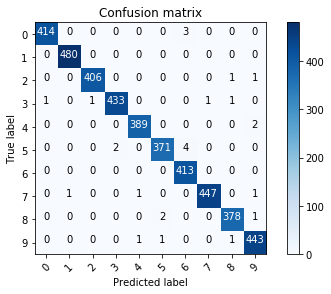

In [12]:
best = save_best_model(10, "../n_output", 5, ".hdf5")
best="../n_output/"+best
print(best)
best_model = model()
best_model.load_weights(best)

# Predict the values from the validation dataset
Y_pred = best_model.predict(val_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(val_Y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [13]:
false_pred = []
for i in range(len(Y_true)):
    if Y_pred_classes[i]!=Y_true[i]:
        false_pred.append(i)
print(false_pred)
false_pred_X=[]
false_pred_Y=[]
for i in false_pred:
    false_pred_X.append(val_X[i].tolist())
    false_pred_Y.append(val_Y[i].tolist())

print(np.asarray(false_pred_Y))

[44, 283, 307, 914, 948, 989, 992, 1001, 1085, 1840, 1855, 2292, 2331, 2455, 2489, 2544, 2597, 2636, 2781, 2886, 3063, 3659, 3704, 3943, 4014, 4086]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 

In [14]:
new_train_X=train_X 
new_train_Y=train_Y
for e in range(10):
    new_train_Y=np.concatenate((new_train_Y, np.asarray(false_pred_Y)), axis=0)
    new_train_X=np.concatenate((new_train_X, np.asarray(false_pred_X)), axis=0)


In [15]:
file_path = "../n_output1"
directory = os.path.dirname(file_path)

try:
    os.makedirs("../n_output1")
except FileExistsError:
    # directory already exists
    pass

print(os.listdir("../n_output1"))

[]


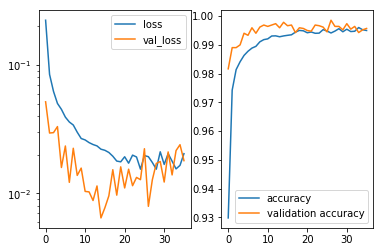


Epoch 00036: val_acc did not improve from 0.99857
Epoch 37/50
 3840/38060 [==>...........................] - ETA: 5s - loss: 0.0168 - acc: 0.9951

In [16]:
my_model2 = model()
checkpoint = ModelCheckpoint('../n_output1/{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
my_model2.fit(new_train_X, new_train_Y, batch_size = 32, epochs = 50,validation_data = (val_X, val_Y),callbacks=[plot,checkpoint])

../n_output/0.9938.hdf5


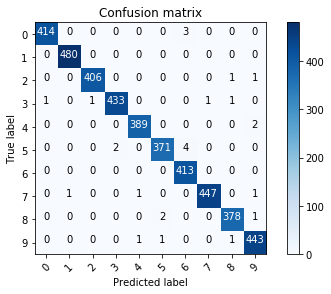

In [17]:
best1 = save_best_model(10, "../n_output1", 5, ".hdf5")
best1="../n_output1/"+best
print(best)
best_model = model()
best_model.load_weights(best1)

# Predict the values from the validation dataset
Y_pred = best_model.predict(val_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(val_Y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [18]:
predictions = best_model.predict(test_X)


5


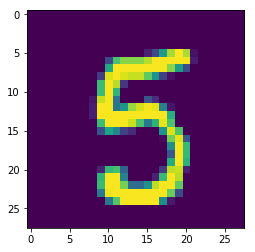

In [19]:
print(np.argmax(predictions[10]))
plt.imshow(test_X[10][:,:,0])

In [20]:
model_pred = np.argmax(predictions,axis=1)
submission_df = pd.read_csv("../input/sample_submission.csv")
submission_df['Label']=model_pred
submission_df.head()

ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3

In [21]:
submission_df.to_csv('submission.csv',index=False)